# Building coilsPy from scratch 

## Step 1: Normalized Generation Scheme
First we need a reliable way of generating a tensor of complex numbers that sum to be some specified point along the complex unit circle. To help, let's use a simple function to plot out complex tensors tip-to-tail to ensure they meet this criteria.

In [169]:
import matplotlib.pyplot as plt
import numpy as np

def plot_complex_vectors(complex_array):
    # Plot the unit circle
    angles = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(angles), np.sin(angles), linestyle='dotted')

    # Starting point for the vectors
    start = 0 + 0j
    for z in complex_array:
        # Plot each vector
        end = start + z
        plt.arrow(start.real, start.imag, z.real, z.imag,
                  head_width=0.05, head_length=0.05, length_includes_head=True)
        start = end

    # Set equal scaling and labels
    plt.axis('equal')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.grid(True)
    plt.title('Complex Vectors Summation')

    # Show the plot
    plt.show()

## Create Kernels

For creating dirichlet distributions we will introduce some kernel options.

There are a number of ways I can accomplish our needs, but currently I am using the following approach:

tensor([3.7267e-06, 3.3546e-04, 1.1109e-02, 1.3534e-01, 6.0653e-01, 1.0000e+00,
        6.0653e-01, 1.3534e-01, 1.1109e-02, 3.3546e-04])


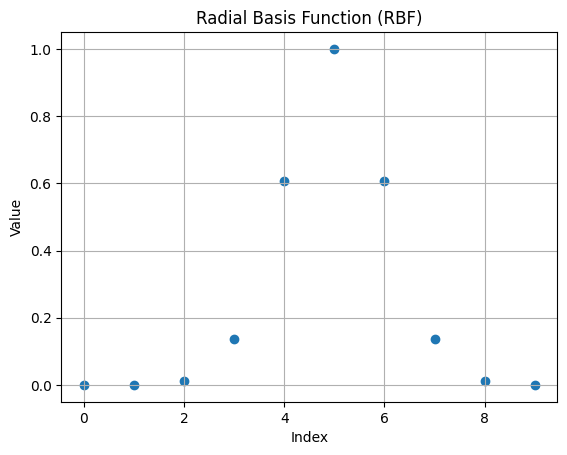

In [170]:
import torch

def generate_rbf(length, center_index, sigma):
    """
    Generates a 1D radial basis function (Gaussian) of specified width centered on a given index.

    Parameters:
    length (int): The length of the output tensor.
    center_index (int): The index at which the RBF is centered.
    sigma (float): The standard deviation (width) of the RBF.

    Returns:
    torch.Tensor: A 1D tensor representing the radial basis function.
    """
    if center_index >= length or center_index < 0:
        raise ValueError("Center index must be within the range of the tensor length.")

    # Create an array of indices
    x = torch.arange(0, length, dtype=torch.float32)

    # Calculate the RBF
    rbf = torch.exp(-0.5 * ((x - center_index) / sigma) ** 2)

    return rbf

def generate_kernel(length, center_index, type = "rbf", restrictions = [], **kwargs):
    if type == "rbf":
        kernel = generate_rbf(length, center_index, kwargs['sigma'])
        
    # Replace zero values with min_value
    kernel = torch.where(kernel == 0, torch.tensor(1e-30, dtype=kernel.dtype), kernel)
    
    # Set restrictions to 0
    kernel[restrictions] = 1e-30
    
    return kernel


# Example usage
length = 10  # Length of the tensor
center_index = 5  # Center the RBF at index 5
sigma = 1  # Standard deviation of the RBF

rbf_tensor = generate_kernel(length, center_index, type = "rbf", sigma=sigma)
print(rbf_tensor)

# Plotting the RBF
plt.scatter(torch.arange(length), rbf_tensor)
plt.title("Radial Basis Function (RBF)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [171]:
def rescale_array_to_target_torch(tensor, target_sum):
    # Create a mask for non-zero elements
    non_zero_mask = tensor > 1e-10

    # Calculate the sum of non-zero elements
    sum_non_zero = torch.sum(tensor[non_zero_mask])

    # Count the non-zero elements
    count_non_zero = torch.sum(non_zero_mask)
    
    # Avoid division by zero in case all elements are zero
    if count_non_zero == 0:
        return torch.zeros_like(tensor)

    # Calculate the required adjustment to reach the target sum
    adjustment = (target_sum - sum_non_zero) / count_non_zero
    
    # Add the adjustment to each non-zero element
    tensor[non_zero_mask] += adjustment

    return tensor

In [172]:
sum(torch.distributions.Dirichlet(torch.tensor([5.1, 0.5])).sample())

tensor(1.)

C:\Users\johnm\AppData\Local\Temp\ipykernel_18124\4025517829.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotated_complex_numbers = torch.tensor(rotated_complex_numbers, dtype=torch.complex128)


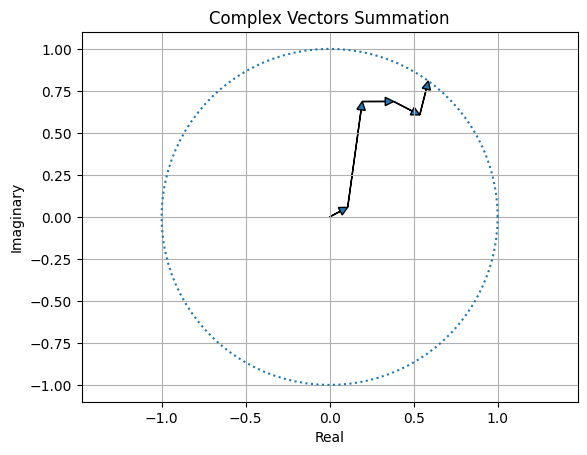

In [173]:
import torch

def dirichlet_to_goal(goal_value, num_elements, center_index, sigma, magnitude, restrictions):
    # Generate alphas for dirichlet
    alphas = generate_kernel(length = num_elements, center_index = center_index, type = "rbf", sigma = sigma, restrictions = restrictions) * magnitude
    rand_samples = torch.distributions.Dirichlet(alphas).sample()
    
    rand_samples = rescale_array_to_target_torch(rand_samples, goal_value)
    
    return rand_samples

def generate_complex_sum(goal_theta, num_elements, center_index_re, center_index_im, sigma_re, sigma_im, magnitude_re, magnitude_im, restrictions = []):
    real_goal = torch.cos(goal_theta)
    imag_goal = torch.sin(goal_theta)
    real_parts = dirichlet_to_goal(1.0, num_elements, center_index_re, sigma_re, magnitude_re, restrictions)
    imag_parts = dirichlet_to_goal(0.0, num_elements, center_index_im, sigma_im, magnitude_im, restrictions)
    complex_numbers = torch.complex(real_parts, imag_parts)
    
    # Step 4: Rotate the entire set of vectors by the goal theta
    rotated_complex_numbers = complex_numbers * (real_goal + imag_goal * 1j)
    
    rotated_complex_numbers = torch.tensor(rotated_complex_numbers, dtype=torch.complex128)

    return rotated_complex_numbers

# Example usage
theta = torch.tensor([0.3 * torch.pi], dtype=torch.float64)  # 90 degrees, should sum to i
complex_array = generate_complex_sum(theta, 
                                     num_elements = 5, 
                                     center_index_re = 0, 
                                     center_index_im = 0, 
                                     sigma_re = 1e100, 
                                     sigma_im = 1e100, 
                                     magnitude_re = 1, 
                                     magnitude_im = 1,
                                     restrictions = [])
plot_complex_vectors(complex_array.numpy())

In [174]:
sum(dirichlet_to_goal(1e-10, num_elements = 4, center_index=0, sigma=100, magnitude = 1, restrictions = []))

tensor(5.9605e-08)

In [175]:
torch.quantize_per_tensor(torch.tensor([-1.0, 0.0, 1.0, 2.0], dtype=torch.float32), torch.tensor(0.1), torch.tensor(10), torch.quint8)

tensor([-1.,  0.,  1.,  2.], size=(4,), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.10000000149011612,
       zero_point=10)

In [176]:
alphas = torch.tensor([1.0, 1.0, 1.0, 1.0], dtype=torch.float32)
samples = torch.distributions.Dirichlet(alphas).sample()
print(samples)
refactors = samples - 1/4
refactors = refactors - sum(refactors)/4
refactors = refactors - sum(refactors)/4
refactors = refactors - sum(refactors)/4
refactors = refactors - sum(refactors)/4
print(sum(refactors))

tensor([0.2522, 0.4393, 0.1975, 0.1110])
tensor(0.)


## Renormalization

In theory, the previous steps should ensure conservation. However, even when using a precision of complex128, there are still memory errors that cause us to lose conservation. Therefore we can optionally renormalize. 

In [177]:
def renormalize_to_unit_circle(array, dim = 1):
    """
    Renormalizes an array of complex numbers so that it sums to a point on the unit circle.

    Parameters:
    array (torch.Tensor): A 1D tensor of complex numbers.

    Returns:
    torch.Tensor: A renormalized 1D tensor of complex numbers.
    """
    current_sum = torch.sum(array, dim = dim)
    # Calculate the magnitude of the current sum
    magnitude = torch.abs(current_sum)

    # Calculate the scale factor
    scale_factor = 1 / magnitude

    # Renormalize the array
    renormalized_array = array * scale_factor

    return renormalized_array
    

## Initial State Generation

This function alone is sufficient for generating our initial state, so let's make some helper functions to generate our initial transition tensor and interaction tensor. 

In [178]:
# Transition tensor create:
def initialize_transition_tensor(num_elements, theta, restrict_dict = []):
    # Create a list to store each column
    columns = []
    num_columns = num_elements

    for col in range(num_columns):
        
        if col in restrict_dict:
            restrictions = restrict_dict[col]
        else:
            restrictions = []
                    
        column = generate_complex_sum(theta, 
                    num_elements = num_elements, 
                    center_index_re = col, 
                    center_index_im = 0, 
                    sigma_re = torch.rand(1)[0]*0.3 + 0.2, 
                    sigma_im = 1e10, 
                    magnitude_re = 1.0, 
                    magnitude_im = 1e5,
                    restrictions = restrictions)
        columns.append(column.unsqueeze(1))  # Add a dimension to make it a column

    # Combine columns into a matrix
    transition_tensor = torch.cat(columns, dim=1)
    
    return transition_tensor

In [179]:
# Interaction Tensor Create:
def initialize_interaction_tensor(num_elements, theta, restrict_dict = []):
    # Example usage
    num_3d_tensors = num_elements + 1  # Number of 3D tensors in the 4D tensor
    num_matrices = num_elements  # Number of 2D matrices in each 3D tensor
    num_columns = num_elements  # Number of columns in each 2D matrix

    # Create a list to store each 3D tensor
    tensors_3d = []

    for _ in range(num_3d_tensors):
        matrices = []
        for _ in range(num_matrices):
            columns = []
            for col in range(num_columns):
                
                if col in restrict_dict:
                    restrictions = restrict_dict[col]
                else:
                    restrictions = []
                    
                column = generate_complex_sum(theta, 
                                    num_elements = num_elements, 
                                    center_index_re = col, 
                                    center_index_im = 0, 
                                    sigma_re = torch.rand(1)[0]*0.3 + 0.2, 
                                    sigma_im = 1e10, 
                                    magnitude_re = 1.0, 
                                    magnitude_im = 1e5,
                                    restrictions = restrictions)
                columns.append(column.unsqueeze(1))  # Add a dimension to make it a column
            matrix = torch.cat(columns, dim=1)
            matrices.append(matrix)  # Add a dimension to make it a 2D matrix
        tensor_3d = torch.stack(matrices, dim=2)
        tensors_3d.append(tensor_3d)

    # Combine 3D tensors into a 4D tensor
    # Stack along the fourth dimension
    interaction_tensor = torch.stack(tensors_3d, dim=3)
    
    return interaction_tensor

Now we can generate all the starting states:

In [180]:
num_elements = 5

# Thetas for state, transition, and interactions
angles_dict = {
    'state': 0.3,
    'transition': 0.2,
    'interaction': 0.4
}


# Set restrictions

# Local
# restrict_dict = {
#     0: [2, 3, 4],
#     1: [3, 4],
#     2: [0, 4],
#     3: [0, 1],
#     4: [0, 1, 2]
# }

# Grouping
# restrict_dict = {
#     0: [2, 3, 4],
#     1: [2, 3, 4],
#     2: [0, 1],
#     3: [0, 1],
#     4: [0, 1]
# }

# No restrictions
restrict_dict = {}

thetas_dict = {key : torch.tensor([value * torch.pi], dtype=torch.float64) for key, value in angles_dict.items()}

# Establish state_tensor
state_tensor = generate_complex_sum(thetas_dict['state'], 
                                     num_elements = num_elements, 
                                     center_index_re = 0, 
                                     center_index_im = 0, 
                                     sigma_re = 1e100, 
                                     sigma_im = 1e100, 
                                     magnitude_re = 1, 
                                     magnitude_im = 100,
                                     restrictions = [])
transition_tensor = initialize_transition_tensor(theta = thetas_dict['transition'], num_elements = num_elements, restrict_dict=restrict_dict)
interaction_tensor = initialize_interaction_tensor(theta = thetas_dict['interaction'], num_elements = num_elements, restrict_dict=restrict_dict)

# Move everything to GPU
state_tensor = state_tensor.to('cuda:0')
transition_tensor = transition_tensor.to('cuda:0')
interaction_tensor = interaction_tensor.to('cuda:0')

state_tensor.device

C:\Users\johnm\AppData\Local\Temp\ipykernel_18124\4025517829.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotated_complex_numbers = torch.tensor(rotated_complex_numbers, dtype=torch.complex128)


device(type='cuda', index=0)

In [181]:
print("State Sum: ",sum(state_tensor * torch.conj(state_tensor.sum(-1))))
print("Transition Sum: ",sum(transition_tensor[:,3] * torch.conj(transition_tensor[:,3].sum())))
print("Interaction Sum: ",sum(interaction_tensor[:,3,1,2] * torch.conj(interaction_tensor[:,3,1,2].sum())))

State Sum:  tensor(1.0000+4.1633e-17j, device='cuda:0', dtype=torch.complex128)
Transition Sum:  tensor(1.0000-4.3368e-19j, device='cuda:0', dtype=torch.complex128)
Interaction Sum:  tensor(1.0000-2.1142e-18j, device='cuda:0', dtype=torch.complex128)


Add batch dimensions to state tensors and transition tensors

In [182]:
state_tensor = state_tensor.unsqueeze(0)
transition_tensor = transition_tensor.unsqueeze(0)

Combined state and transition tensors into a norm_subgroups tensor

In [183]:
norm_subgroups = torch.cat((state_tensor.unsqueeze(-1), transition_tensor), dim=2)

Some checks to make sure norm_subgroups is set up correctly

In [184]:
print(torch.isclose(norm_subgroups[0,:,5] , transition_tensor[0,:,4]))
print(torch.isclose(norm_subgroups[0,:,0] , state_tensor[0,:]))
print(torch.isclose(norm_subgroups[0,:,2] , transition_tensor[0,:,1]))

tensor([True, True, True, True, True], device='cuda:0')
tensor([True, True, True, True, True], device='cuda:0')
tensor([True, True, True, True, True], device='cuda:0')


We can get the candidate transition tensors like this

In [185]:
candidate_transition_tensors = (torch.mul(interaction_tensor, norm_subgroups.unsqueeze(1).unsqueeze(1))).sum(-2) # [batches, states, states, states + 1]
print(candidate_transition_tensors.shape)

torch.Size([1, 5, 5, 6])


We can confirm this is correct by doing an individual slice

In [186]:
slice_sel = 3
batch_sel = 0
slice_transition_check = torch.matmul(interaction_tensor[:,:,:,slice_sel],norm_subgroups[batch_sel ,:,slice_sel])

torch.isclose(candidate_transition_tensors[batch_sel,:,:,slice_sel], slice_transition_check)

tensor([[True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True]], device='cuda:0')

In [187]:
sum(slice_transition_check[:,1] * torch.conj(torch.sum(slice_transition_check[:,1])))
sum(candidate_transition_tensors[batch_sel,:,3,slice_sel] * torch.conj(torch.sum(candidate_transition_tensors[batch_sel,:,3,slice_sel])))

tensor(1.0000+4.6851e-17j, device='cuda:0', dtype=torch.complex128)

Now to do a selection that preserves the gradients, we have to figure out a couple things. One, how do we determine which slice maximizes the probability of going from the largest state to the smallest state? 

In [188]:
def complex_add(tensor):
    return torch.abs(torch.real(tensor)+torch.imag(tensor))

sel_temperature = 0.001

I propose we use this absolute complex add as a measure of magnitude, and determine the largest and smallest state:

In [189]:
high_magnitude = torch.softmax((complex_add(state_tensor) / sel_temperature), dim = 1)
low_magnitude = torch.softmax(1 - (complex_add(state_tensor) / sel_temperature), dim = 1)
largest_state = torch.where(high_magnitude == high_magnitude.max())[1][0]
smallest_state = torch.where(low_magnitude == low_magnitude.max())[1][0]
print("State Tensor: ", state_tensor)
print("Largest State: ",largest_state)
print("Smallest State: ", smallest_state)

State Tensor:  tensor([[0.1907+0.2752j, 0.1415+0.1556j, 0.0558+0.0542j, 0.0778+0.1016j,
         0.1220+0.2224j]], device='cuda:0', dtype=torch.complex128)
Largest State:  tensor(0, device='cuda:0')
Smallest State:  tensor(2, device='cuda:0')


If we've done this right, the largest of these tensors should be the slice with the largest transition from our largest state to our smallest state

In [190]:
candidate_transition_tensors.shape
high_magnitude.shape

torch.Size([1, 5])

In [191]:
high_magnitude.unsqueeze(2).unsqueeze(1)

tensor([[[[ 1.0000e+00],
          [ 4.7282e-74],
          [2.4951e-155],
          [3.6768e-125],
          [ 1.6789e-53]]]], device='cuda:0', dtype=torch.float64)

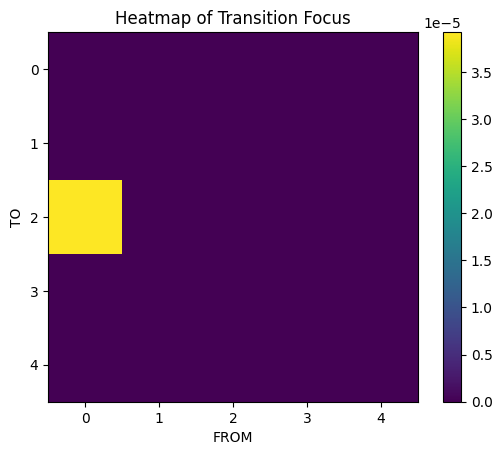

In [192]:
tensor_2d = complex_add(torch.mul(torch.mul(candidate_transition_tensors, high_magnitude.unsqueeze(2).unsqueeze(1)), low_magnitude.unsqueeze(2).unsqueeze(2))[0,:,:,2])
# Convert the tensor to a numpy array
tensor_2d_np = tensor_2d.to("cpu").numpy()

# Create a heatmap using matplotlib
plt.imshow(tensor_2d_np, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show color scale
plt.title('Heatmap of Transition Focus')
plt.xlabel('FROM')
plt.ylabel('TO')
plt.show()

In [193]:
selection_weights = torch.softmax(complex_add(torch.mul(torch.mul(candidate_transition_tensors, high_magnitude.unsqueeze(2).unsqueeze(1)), low_magnitude.unsqueeze(2).unsqueeze(2))).sum(2).sum(1) / sel_temperature, dim = 1)
print(torch.where(selection_weights == selection_weights.max())[1][0])
print(selection_weights)

tensor(1, device='cuda:0')
tensor([[0.1584, 0.2245, 0.1377, 0.1701, 0.1703, 0.1389]], device='cuda:0',
       dtype=torch.float64)


Note that dim = 1 (rows) corresponds to the "To" state, while dim = 2 (columns) corresponds to the "From" state. 

In [194]:
slice_sel = complex_add(candidate_transition_tensors[:,smallest_state, largest_state, :])
print(torch.where(slice_sel == slice_sel.max())[1][0])

tensor(1, device='cuda:0')


In [195]:
selection_weights

tensor([[0.1584, 0.2245, 0.1377, 0.1701, 0.1703, 0.1389]], device='cuda:0',
       dtype=torch.float64)

In [196]:
candidate_transition_tensors.shape

torch.Size([1, 5, 5, 6])

In [197]:
new_state_a = torch.mul(transition_tensor, state_tensor.unsqueeze(1)).sum(dim = -1)

In [198]:
new_state_b = torch.matmul(transition_tensor[0,:,:], state_tensor[0,:])

In [199]:
torch.isclose(new_state_a, new_state_b)

tensor([[True, True, True, True, True]], device='cuda:0')

In [200]:
sum(new_state_a[0,:] * torch.conj(new_state_a[0,:].sum()))

tensor(1.0000+0.j, device='cuda:0', dtype=torch.complex128)

Now that we have our selection weights, we can finally apply it to the candidate selection tensors

We can't apply the selection weights to the slices directly because that normalization trick only works for square matrices, so instead we can rotate everything to 1+0i, do a traditional weighted sum, and rotate back. 

In [201]:
candidate_transition_tensors[0,:,2,1] * torch.conj(sum(candidate_transition_tensors[0,:,2,1]))

tensor([ 5.0512e-07-0.0004j, -3.2406e-07+0.0006j,  1.0000e+00-0.0001j,
         1.1806e-06-0.0009j,  3.1731e-08+0.0008j], device='cuda:0',
       dtype=torch.complex128)

In [202]:
# We can do a rotate there-and-back to 1+0i like this
torch.isclose(candidate_transition_tensors,(candidate_transition_tensors * torch.conj(torch.sum(candidate_transition_tensors, dim = 1))) / torch.conj(torch.sum(candidate_transition_tensors, dim = 1)))

tensor([[[[True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True]],

         [[True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True]],

         [[True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True]],

         [[True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True]],

         [[True, True, True, Tru

In [203]:
rotated_candidate_transition_tensors = (candidate_transition_tensors * torch.conj(torch.sum(candidate_transition_tensors, dim = 1)))

In [204]:
selected_transition_tensor = torch.mul(rotated_candidate_transition_tensors, selection_weights.unsqueeze(1).unsqueeze(1)).sum(-1) / torch.conj(torch.sum(candidate_transition_tensors[:,:,:,0], dim = 1))

In [205]:
# Check normalization
torch.sum(selected_transition_tensor * torch.conj(torch.sum(selected_transition_tensor, dim = 1)), dim =1)

tensor([[1.0000-1.4027e-17j, 1.0000-9.2825e-17j, 1.0000-9.4055e-18j,
         1.0000+2.6292e-17j, 1.0000-4.6675e-17j]], device='cuda:0',
       dtype=torch.complex128)

In [206]:
sum(selected_transition_tensor[0,:,3] * torch.conj(selected_transition_tensor[0,:,3].sum()))

tensor(1.0000+9.1534e-17j, device='cuda:0', dtype=torch.complex128)

# Transition Tensor Selection

In [207]:
def select_transition_tensor(state_tensor,transition_tensor,interaction_tensor, sel_temperature):
    # Combine state and transition tensors into a norm_subgroups tensor
    norm_subgroups = torch.cat((state_tensor.unsqueeze(-1), transition_tensor), dim=2)
    
    # Get candidate transition tensors:
    candidate_transition_tensors = (torch.mul(interaction_tensor, norm_subgroups.unsqueeze(1).unsqueeze(1))).sum(-2) # [batches, states, states, states + 1]
    
    # Determine the largest and smallest states
    high_magnitude = torch.softmax((complex_add(state_tensor) / sel_temperature), dim = 1)
    low_magnitude = torch.softmax(1 - (complex_add(state_tensor) / sel_temperature), dim = 1)
    
    # Find which transition corresponds to moving from the highest state to the lowest state, and focus on that:
    transition_focus_slices = complex_add(torch.mul(torch.mul(candidate_transition_tensors, high_magnitude.unsqueeze(2).unsqueeze(1)), low_magnitude.unsqueeze(2).unsqueeze(2)))
    
    # Determine the selection weights by which slice is the highest in the focus transition
    selection_weights = torch.softmax(transition_focus_slices.sum(2).sum(1) / sel_temperature, dim = 1)
    
    # Rotate the candidate transition tensors to 1+0i so that we can do a weighted average
    rotated_candidate_transition_tensors = (candidate_transition_tensors * torch.conj(torch.sum(candidate_transition_tensors, dim = 1)))
    
    # Perform weighted averaging and rotate back to the original position (NOTE: we just use the first rotation here because they should all be the same in our case)
    selected_transition_tensor = torch.mul(rotated_candidate_transition_tensors, selection_weights.unsqueeze(1).unsqueeze(1)).sum(-1) / torch.conj(torch.sum(candidate_transition_tensors[:,:,:,0], dim = 1))
    
    return selected_transition_tensor
    
    

In [208]:
initial_state_tensor = state_tensor
initialize_transition_tensor = transition_tensor

In [209]:
import time

tic = time.time()

num_steps = 10_000
prob_save = []

# Load tensors
#state_tensor = torch.load('../saved_tensors/state_tensor_20240328_phaseshift.pt').unsqueeze(0).to("cuda")
#transition_tensor = torch.load('../saved_tensors/transition_tensor_20240328_phaseshift.pt').unsqueeze(0).to("cuda")
#interaction_tensor = torch.load('../saved_tensors/interaction_tensor_20240328_phaseshift.pt').to("cuda")

# state_tensor = renormalize_to_unit_circle(state_tensor)
# transition_tensor = renormalize_to_unit_circle(transition_tensor)
# interaction_tensor = renormalize_to_unit_circle(interaction_tensor, dim = 0)  

state_tensor = initial_state_tensor
transition_tensor = initialize_transition_tensor


for i_step in range(num_steps):
    transition_tensor = select_transition_tensor(state_tensor,transition_tensor,interaction_tensor, sel_temperature = 1e-5)
    
    #print(sum(transition_tensor[0,:,3] * torch.conj(transition_tensor[0,:,3].sum())))
    #print(torch.sum(state_tensor* torch.conj(torch.sum(state_tensor, dim = -1)), dim = -1)[0].real)
    state_tensor = torch.mul(transition_tensor, state_tensor.unsqueeze(1)).sum(dim = -1)
    
    #print(state_tensor)
    #plot_complex_vectors(state_tensor[0,:].to('cpu').numpy())

    # Optionally we can renomalize to avoid floating point precision errors
    state_tensor = renormalize_to_unit_circle(state_tensor)
    transition_tensor = renormalize_to_unit_circle(transition_tensor)

    state_prob = torch.real(state_tensor[0,:] * torch.conj(state_tensor[0,:].sum()))

    prob_save.append(state_prob)
    
    
toc = time.time()    
print(f"Processing time: {round(toc-tic,4)}s")
print(state_prob.sum())

Processing time: 14.7677s
tensor(1.0000, device='cuda:0', dtype=torch.float64)


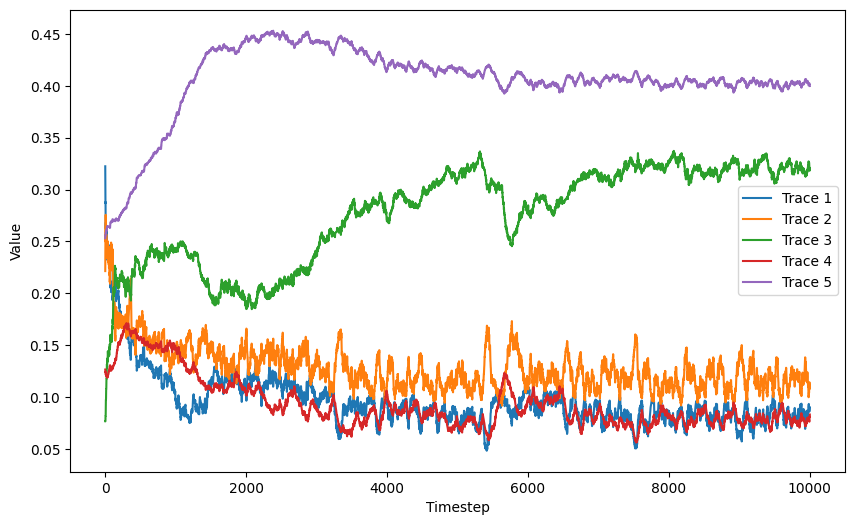

In [210]:
# Your data
data = [row.to('cpu') for row in prob_save]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()